# Interatomic force field (IFF) optimization for W-based metal alloys

## Input data preparation

Author: Lukas Vlcek

Start Date: 2018-04-22

### Explore spline potentials

In [1]:
%matplotlib inline
import sys
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin

### Tungsten EAM IFF functions - cubic splines

In [64]:
# pair potential function (cubic splines)
V = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

# electronic density function (cubic splines)
rho = lambda r, a, k: sum([c*(p - r)**3 for c, p in zip(a, k) if r < p])

# embedding function
#F_old = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2
F = lambda d, a: a[0]*d**0.5 + a[1]*d**2

In [65]:
# fit pair potential
def udif(p, r, phi_a, phi_r, opt_phi_r):
    uref = [V(x, phi_a, phi_r) for x in r]
    utry = [V(x, p, opt_phi_r) for x in r]
    return uref, utry

def uloss(p, r, phi_a, phi_r, opt_phi_r):
    uref = [V(x, phi_a, phi_r) for x in r]
    utry = [V(x, p, opt_phi_r) for x in r]
    loss = sum([(a-b)**2 for a, b in zip(uref, utry)])
    print('loss', loss)
    return loss

# fit manybody potential
def u_manybody_dif(p, r, rho_f, rho_a, rho_r, opt_rho_a, opt_rho_r):
    uref = [F(12*rho(x, rho_a, rho_r), rho_f)/12 for x in r]
    utry = [F(12*rho(x, opt_rho_a, opt_rho_r), p)/12 for x in r]
    return uref, utry

def u_manybody_loss(p, r, rho_f, rho_a, rho_r, opt_rho_a, opt_rho_r):
    uref = [F(12*rho(x, rho_a, rho_r), rho_f)/12 for x in r]
    utry = [F(12*rho(x, opt_rho_a, opt_rho_r), p)/12 for x in r]    
    loss = sum([(a-b)**2 for a, b in zip(uref, utry)])
    return loss

In [66]:
phi_a = [-4.73661687e+01,  2.29965951e+01, -3.42248343e+00,  3.73956980e+00, -1.39292737e+00, -8.33458565e-01, 9.29769431e-01, -1.83568989e-01]
phi_r = [2.5, 2.75, 3.25, 3.75, 4.25, 4.5,  5., 5.5]
rho_f = [-1.21658318e+00,  3.24863580e-05]
rho_a = [1.0]
rho_r = [phi_r[-1]]

opt_phi_a = [-4.73661687e+01,  2.29965951e+01, -3.42248343e+00,  3.73956980e+00, -1.39292737e+00, -8.33458565e-01, 9.29769431e-01, -1.83568989e-01]
opt_phi_r = [2.5, 2.75, 3.25, 3.75, 4.25, 4.5,  5., 5.5]
opt_rho_f = [-1.21658318e+00,  3.24863580e-05]
opt_rho_a = [1.0]
opt_rho_r = [opt_phi_r[-1]]

r = np.linspace(0., opt_rho_r[-1], 201)

In [56]:
def preset_old(opt_phi_r):
    """
    Find starting parameters closest to parameters for different splines.
    """
    
    diff_min = 1e6
    for it in range(1000000):
        node_ids = sorted(np.random.choice(len(opt_phi_r), len(phi_r), replace=False))
        
        diff = sum([(phi_r[i] - opt_phi_r[j])**2 for i, j in enumerate(node_ids)])

        if diff < diff_min:
            diff_min = diff
            nodes_ids_best = node_ids
            print(diff)
                   
    opt_phi_a = [0.0 for _ in range(len(opt_phi_r))]
    for i, j in enumerate(nodes_ids_best):
        opt_phi_a[j] = phi_a[i]
        print('r', i, j, phi_r[i], opt_phi_r[j], opt_phi_a[j])
                       
    return opt_phi_a

In [57]:
def preset(opt_phi_r):
    """
    Find starting parameters closest to parameters for different splines.
    """
    
    opt_phi_a = [0.0 for _ in range(len(opt_phi_r))]

    rmax = -1
    for i, ro in enumerate(phi_r):
        diff_min = 1e6
        for j, rn in enumerate(opt_phi_r):
            if rn <= rmax:
                continue
            diff = abs(ro - rn)
            if diff < diff_min:
                diff_min = diff
                j_min = j
                rmax = rn
                
        opt_phi_a[j_min] = phi_a[i]
        
        print('r', i, j_min, phi_r[i], opt_phi_r[j_min], opt_phi_a[j_min])
                       
    return opt_phi_a

In [58]:
opt_phi_r = [2.4, 2.45, 2.5, 2.65, 2.7, 2.72, 2.73, 2.74, 2.75, 2.77, 2.8, 2.85, 2.9, 3.0, 3.1, 3.2, 3.3, 3.45, 3.6, 3.75, 4.0, 4.1, 4.25, 4.356, 4.5, 4.65, 4.8, 5.0, 5.15, 5.3, 5.45, 5.6, 5.75]

In [78]:
opt_phi_r = [2.4, 2.65, 2.72, 2.75, 3., 3.45, 4., 4.5, 5., 5.6]

In [80]:
opt_phi_a = preset_old(opt_phi_r)

0.24499999999999986
0.23499999999999985
r 0 0 2.5 2.4 -47.3661687
r 1 3 2.75 2.75 22.9965951
r 2 4 3.25 3.0 -3.42248343
r 3 5 3.75 3.45 3.7395698
r 4 6 4.25 4.0 -1.39292737
r 5 7 4.5 4.5 -0.833458565
r 6 8 5.0 5.0 0.929769431
r 7 9 5.5 5.6 -0.183568989


In [81]:
# optimize pair interactions
par_in = opt_phi_a
output = fmin(uloss, par_in, args=(r, phi_a, phi_r, opt_phi_r), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
opt_phi_a = output[0]
print(*opt_phi_a)

loss 122074.62773491042
loss 54633.25188391806
loss 122086.84451661992
loss 122088.02415439073
loss 194576.55548671202
loss 109481.38975339015
loss 146115.70985427595
loss 108322.20613531352
loss 109800.6326061529
loss 142976.57023847214
loss 116406.3661073832
loss 54768.18538556811
loss 69120.22827152496
loss 59636.020545787265
loss 63339.509986185534
loss 53901.03463265908
loss 30203.76717931995
loss 38859.23866537607
loss 31228.89811027387
loss 24326.943085732393
loss 5223.901618113619
loss 10960.6245611962
loss 4227.0957189564515
loss 7496.912269879686
loss 7773.4713194258375
loss 4631.21307950332
loss 2480.58302648012
loss 8127.870026718304
loss 1073.3505750444658
loss 14201.811612398296
loss 2558.838523223119
loss 4335.484808418107
loss 7730.731460243943
loss 18032.064498586868
loss 4123.642310349285
loss 9168.556024689682
loss 2916.303324683205
loss 10168.013704042538
loss 2508.693996022697
loss 9503.62538698863
loss 2561.065564760954
loss 6483.550252140946
loss 1993.53359269256

loss 2.6831550732895515
loss 2.6486362629041427
loss 2.6497265853497427
loss 2.615565959557964
loss 2.654959007837363
loss 2.635382072186787
loss 2.6712790634450756
loss 2.6226046670921197
loss 2.6493874569996416
loss 2.6066991788312386
loss 2.665228603235166
loss 2.6134916406854125
loss 2.603427796158017
loss 2.6822382780039082
loss 2.6576272439346997
loss 2.6112622524278053
loss 2.689613447548468
loss 2.605654938877767
loss 2.6383867355996693
loss 2.5842023034936425
loss 2.6230534774238334
loss 2.62613755476846
loss 2.6599863738964906
loss 2.5979107227835594
loss 2.5765166297884012
loss 2.6016371170155845
loss 2.627221738608582
loss 2.5942385139802258
loss 2.60506939093863
loss 2.5992172829258706
loss 2.6604219671812097
loss 2.5843460461621492
loss 2.636613699115511
loss 2.5863767791420824
loss 2.6139556973916154
loss 2.5872015116113283
loss 2.593395969441777
loss 2.585906244902197
loss 2.5842858667674937
loss 2.6102527755918774
loss 2.5815387652599826
loss 2.5826714879887795
loss 2.

loss 1.3324913130399534
loss 1.3322950849604838
loss 1.3323922448537586
loss 1.332296093925016
loss 1.3324470925144665
loss 1.3322814277995683
loss 1.3323802270949412
loss 1.332288367000311
loss 1.3323349555098953
loss 1.3323184452757966
loss 1.3323429752484224
loss 1.3322801556699941
loss 1.3323631499214135
loss 1.3322766128215189
loss 1.3323491443258582
loss 1.3322760090670516
loss 1.3323366241448056
loss 1.3322735857447643
loss 1.3323232542116605
loss 1.3322741338356354
loss 1.332303186875154
loss 1.3323569999046723
loss 1.3322662592690808
loss 1.3323120126025159
loss 1.3322705596838216
loss 1.3322931220579695
loss 1.3323027672699281
loss 1.332268421703724
loss 1.332292374761693
loss 1.3322683132643733
loss 1.3322836472259814
loss 1.3322653503153974
loss 1.3323015734636101
loss 1.3322633225437759
loss 1.332295919135888
loss 1.3322636249114264
loss 1.3322858458773796
loss 1.3322635165549745
loss 1.3322793946964657
loss 1.332263980000909
loss 1.3322662976628987
loss 1.3322771550486558

loss 1.28184092939727
loss 1.278140982059898
loss 1.2842335748812095
loss 1.277541903864465
loss 1.2875995483889504
loss 1.2787467126026553
loss 1.274771805395817
loss 1.276206887788328
loss 1.2711733625726136
loss 1.2679376220837097
loss 1.2682869175437619
loss 1.2792584518982282
loss 1.2755571200806446
loss 1.2817138748298493
loss 1.274353648987166
loss 1.2721310290790544
loss 1.2673535328210526
loss 1.2646314201711246
loss 1.2717532594400258
loss 1.2687302729722583
loss 1.262485442622923
loss 1.25758302141951
loss 1.2615956605974703
loss 1.2617289018602489
loss 1.2623595173195479
loss 1.2612298788888452
loss 1.2548922261352404
loss 1.2507749555746328
loss 1.256224219859093
loss 1.2546564726901244
loss 1.250645746947097
loss 1.249284833546701
loss 1.2431680915818748
loss 1.234475375666077
loss 1.2433389994062187
loss 1.2418279144903086
loss 1.238518230619769
loss 1.2328134092167715
loss 1.225422079336101
loss 1.230454849408605
loss 1.2446463771155105
loss 1.230390953624619
loss 1.226

loss 0.971843945098035
loss 0.9718445417369056
loss 0.9718437251640757
loss 0.9718444457595855
loss 0.9718437151595752
loss 0.9718443523527567
loss 0.9718437209637814
loss 0.971844051245177
loss 0.9718436633169655
loss 0.9718439158824778
loss 0.971844117825419
loss 0.9718436449782837
loss 0.9718438396747984
loss 0.9718438250384142
loss 0.9718437603854981
loss 0.9718441176066859
loss 0.9718435916298374
loss 0.9718437752139397
loss 0.9718435966695533
loss 0.9718438819912861
loss 0.971843585988234
loss 0.9718437244533161
loss 0.9718436619402967
loss 0.9718438494837052
loss 0.9718435705382814
loss 0.9718437825857258
loss 0.9718435775462081
loss 0.9718435619833034
loss 0.9718438192074607
loss 0.971843574375584
loss 0.9718437698826508
loss 0.9718435374849427
loss 0.9718436663223408
loss 0.9718435476076839
loss 0.9718437159937154
loss 0.9718435365802408
loss 0.9718436310945091
loss 0.9718435320997995
loss 0.971843493091811
loss 0.9718435583350076
loss 0.971843616489923
loss 0.971843521126633


loss 0.9706363956762898
loss 0.9706504068215376
loss 0.9706152865232114
loss 0.9706851342992121
loss 0.9704115714738237
loss 0.9702069894263763
loss 0.9702695259009714
loss 0.9702286502832456
loss 0.9704321925109325
loss 0.9701850576733896
loss 0.9700191683898458
loss 0.9704641546293887
loss 0.9701795534424594
loss 0.970287793070757
loss 0.9701135989312643
loss 0.9698303038927272
loss 0.969521514841687
loss 0.9697310746659283
loss 0.9696928884231241
loss 0.9696534771294175
loss 0.9697516864292118
loss 0.9696603545235398
loss 0.9696924082671625
loss 0.9693570813443195
loss 0.9691291604744832
loss 0.9690820898629438
loss 0.9686526698384863
loss 0.9688114700054855
loss 0.9687944809403094
loss 0.9692637148556963
loss 0.9688395306247811
loss 0.9691998954442977
loss 0.9684206361611966
loss 0.9678503087932012
loss 0.9681624679828971
loss 0.9680993087825851
loss 0.9679739990028564
loss 0.9680335793361752
loss 0.967993080948177
loss 0.9676769741943002
loss 0.9675225559073851
loss 0.967261539825

loss 0.4961024606874751
loss 0.494248251003414
loss 0.5064181117383153
loss 0.48388343785323834
loss 0.4765120459816779
loss 0.49043532513963745
loss 0.5028681072266801
loss 0.48193822444452683
loss 0.48692875443124606
loss 0.4921282001041078
loss 0.4811175111661347
loss 0.47428038680050943
loss 0.4846737736325888
loss 0.47466717198251046
loss 0.4791264208175436
loss 0.4815799281840171
loss 0.4723918333403203
loss 0.48537994986686495
loss 0.49923669398554843
loss 0.4744130384558773
loss 0.4737037251149847
loss 0.4777393864784851
loss 0.4732548064363511
loss 0.47552504445891963
loss 0.46933336539753123
loss 0.4816604320762756
loss 0.48233147652319813
loss 0.47091596390097157
loss 0.47684438844712207
loss 0.4705135189426755
loss 0.4703522977206296
loss 0.47877540554287396
loss 0.4695220472762602
loss 0.4727662937300968
loss 0.4739047845214112
loss 0.4715344223946841
loss 0.47370255515637816
loss 0.48154365656490156
loss 0.4682927804643142
loss 0.4739609010750592
loss 0.4690919494553064
l

loss 0.46653149186680354
loss 0.4665314911096132
loss 0.4665314919286209
loss 0.46653149109425907
loss 0.4665314922886644
loss 0.4665314910373274
loss 0.46653149092340657
loss 0.46653149183110665
loss 0.4665314914309644
loss 0.4665314909434436
loss 0.4665314926134025
loss 0.4665314908094328
loss 0.4665314913837554
loss 0.46653149093690865
loss 0.46653149166679564
loss 0.466531490882186
loss 0.46653149100483143
loss 0.4665314909785279
loss 0.4665314911165034
loss 0.4665314908565074
loss 0.46653149076286543
loss 0.46653149111080144
loss 0.4665314910477491
loss 0.4665314908151183
loss 0.46653149101158475
loss 0.466531490802481
loss 0.46653149100818564
loss 0.4665314908020195
loss 0.4665314911774377
loss 0.4665314907760701
loss 0.4665314908373242
loss 0.466531490753867
loss 0.4665314910417899
loss 0.4665314911146489
loss 0.46653149074532374
loss 0.4665314909988515
loss 0.4665314907441376
loss 0.4665314908745089
loss 0.46653149074809847
loss 0.4665314908442527
loss 0.46653149074406736
loss 

In [82]:
# optimize manybody interactions
opt_rho_r = [opt_phi_r[-1]]
par_in = opt_rho_f
output = fmin(u_manybody_loss, par_in, args=(r, rho_f, rho_a, rho_r, opt_rho_a, opt_rho_r), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
opt_rho_f = output[0]
print(*opt_rho_f)

-1.1825596913794016 2.8944059727957714e-05


In [159]:
# electronic density parameters
rho_re_a = [3.704045964e-3]
rho_re_r = [5.46]

# embeding function parameters
F_re_a = [-7.046791948, 1.23658472, 1.143405627]
#F_re_a = [-7.046791948, 0, 1.143405627]

# pair potential
V_re_a = [6.726805309, 3.217593889, -6.545857587e-1, 1.453229484e-1, -2.063629464e-1, 6.114909116e-2]
V_re_r = [2.7, 3.252, 3.804, 4.356, 4.908, 5.46]

In [160]:
def utot_re(x):
    u = 6*V(x, V_re_a, V_re_r)
    d = 12*rho(x, rho_re_a, rho_re_r)
    u += F(d, F_re_a)
    return u/12

def u_manybody_re(x):
    d = 12*rho(x, rho_re_a, rho_re_r)
    u = F(d, F_re_a)
    return u/12

(201,) (2, 201)


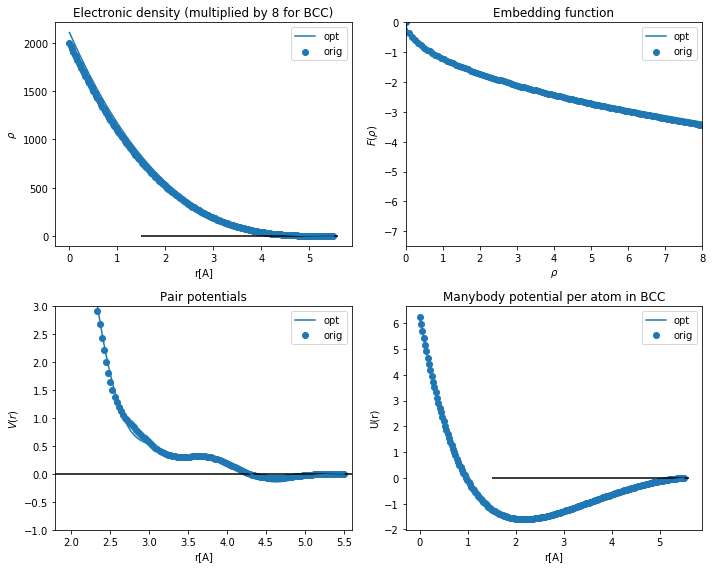

In [83]:
# plot the functions and potentials
rcut = opt_rho_r[-1]

plt.figure(figsize=(10,8))

# Electronic density
dens = [rho(x, rho_a, rho_r)*12 for x in r]
dens_opt = [rho(x, opt_rho_a, opt_rho_r)*12 for x in r]

plt.subplot(221)
plt.title('Electronic density (multiplied by 8 for BCC)')
plt.scatter(r, dens, label='orig')
plt.plot(r, dens_opt, label='opt')
plt.legend()
plt.hlines(1.0, 1.5, rcut)
#plt.axis([1.5, rcut, 0, 0.3*8])
plt.xlabel('r[A]')
plt.ylabel(r'$ \rho $')

# Embedding function
dens = np.linspace(0., 8., 101)
embed = [F(d, rho_f) for d in dens]
embed_opt = [F(d, opt_rho_f) for d in dens_opt]

plt.subplot(222)
plt.title('Embedding function')
plt.scatter(dens, embed, label='orig')
plt.plot(dens_opt, embed_opt, label='opt')

plt.legend()
plt.axis([0, 8, -7.5, 0.0])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$F(\rho)$')

# Pair and manybody potentials
pot = [V(x, phi_a, phi_r) for x in r]
pot_opt = [V(x, opt_phi_a, opt_phi_r) for x in r]
plt.subplot(223)
plt.title('Pair potentials')
plt.scatter(r, pot, label='orig')
plt.plot(r, pot_opt, label='opt')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.8, rcut, -1.0, 3.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

# Total potential per atom (bulk)
uboth = np.array(u_manybody_dif(opt_rho_f, r, rho_f, rho_a, rho_r, opt_rho_a, opt_rho_r))
print(r.shape, uboth.shape)
plt.subplot(224)
plt.title('Manybody potential per atom in BCC')
plt.scatter(r, uboth[0,:], label='orig')
plt.plot(r, uboth[1,:], label='opt')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
#plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

plt.tight_layout()

In [209]:
# electronic density parameters
rho_x_a = [1.0]
rho_x_r = [5.48]

# embeding function parameters
#F_re_a = [-7.046791948, 0, 1.143405627]
#F_x_a = [-7.046791948, 1.23658472, 1.143405627]
F_x_a = [-7.046791948, 0.0, 1.143405627]



#3.704045964e-3

# pair potential
V_x_a = [x*2 for x in V_re_a][:]
#V_x_r = [2.74, 3.25, 3.75, 4.5, 5.48]
#V_x_r = [2.75, 3.25, 3.75, 4.356, 5.0, 5.5]
V_x_r = [2.5, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75]

V_x_a += [0.0, 0.0]
V_x_a

[13.453610618,
 6.435187778,
 -1.3091715174,
 0.2906458968,
 -0.4127258928,
 0.12229818232,
 0.0,
 0.0]

In [210]:
def utot_re(x):
    u = 6*V(x, V_re_a, V_re_r)
    d = 12*rho(x, rho_re_a, rho_re_r)
    u += F(d, F_re_a)
    return u/12

def u_manybody_re(x):
    d = 12*rho(x, rho_re_a, rho_re_r)
    u = F(d, F_re_a)
    return u/12


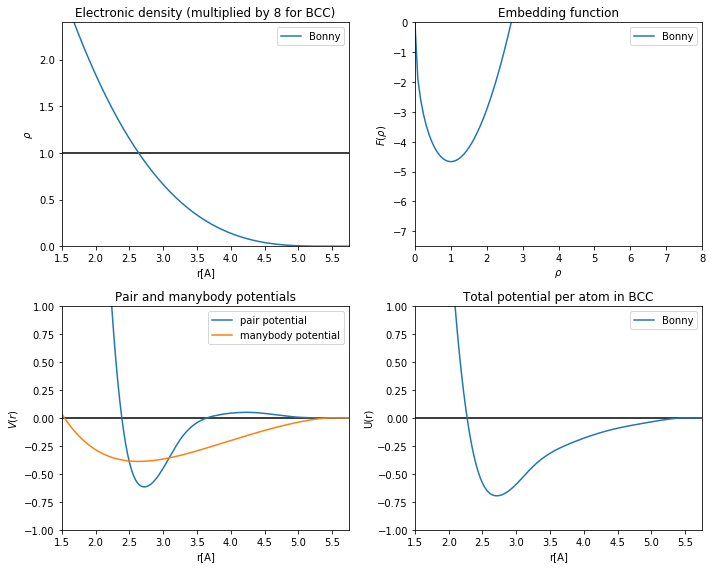

In [211]:
# plot the functions and potentials
rcut = 5.75
r = np.linspace(0., rcut, 201)

plt.figure(figsize=(10,8))

# Electronic density
dens = [rho(x, rho_re_a, rho_re_r)*12 for x in r]
plt.subplot(221)
plt.title('Electronic density (multiplied by 8 for BCC)')
plt.plot(r, dens, label='Bonny')
plt.legend()
plt.hlines(1.0, 1.5, rcut)
plt.axis([1.5, rcut, 0, 0.3*8])
plt.xlabel('r[A]')
plt.ylabel(r'$ \rho $')

# Embedding function
dens = np.linspace(0., 8., 101)
embed = [F(d, F_re_a) for d in dens]
plt.subplot(222)
plt.title('Embedding function')
plt.plot(dens, embed, label='Bonny')
plt.legend()
plt.axis([0, 8, -7.5, 0.0])
plt.xlabel(r'$\rho$')
plt.ylabel(r'$F(\rho)$')

# Pair and manybody potentials
pot = [V(x, V_re_a, V_re_r) for x in r]
pot_manybody = [u_manybody_re(x) for x in r]
plt.subplot(223)
plt.title('Pair and manybody potentials')
plt.plot(r, pot, label='pair potential')
plt.plot(r, pot_manybody, label='manybody potential')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

# Total potential per atom (bulk)
pot = [utot_re(x) for x in r]
plt.subplot(224)
plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='Bonny')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

plt.tight_layout()

Text(0,0.5,'$V(r)$')

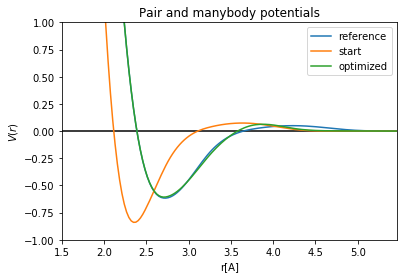

In [214]:
rcut = 5.46
r = np.linspace(0., rcut, 201)

uref, utry = udif(V_x_a, r)
uref, uopt = udif(pair_new, r)

plt.title('Pair and manybody potentials')
plt.plot(r, uref, label='reference')
plt.plot(r, utry, label='start')
plt.plot(r, uopt, label='optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

-0.344540412587315 1.6869558429105695e-05


[-7.046791948, 1.23658472, 1.143405627]


Text(0,0.5,'$V(r)$')

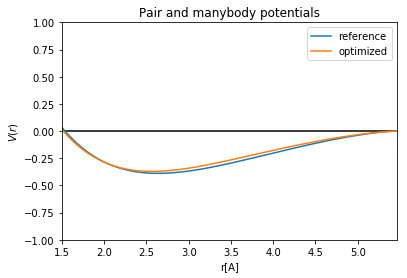

In [217]:
rcut = 5.46
r = np.linspace(0., rcut, 201)
print(F_re_a)
uref, utry = u_manybody_dif(F_re_a, r)
uref, uopt = u_manybody_dif(many_new, r)

plt.title('Pair and manybody potentials')
plt.plot(r, uref, label='reference')
#plt.plot(r, utry, label='start')
plt.plot(r, uopt, label='optimized')

plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1.0, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'$V(r)$')

In [218]:
many_x = list(many_new)
pair_x = list(pair_new)

In [219]:
print(many_x + pair_x)

[-0.344540412587315, 1.6869558429105695e-05, 0.4527535290774057, 7.091857873610367, 1.6314949612839302, 0.7906877956550405, -0.8249673243680319, 0.14501087706040938, -0.002061634677032549, 0.0021894588902290147]


In [220]:
pars_in = {'pair':pair_x, 'embed':many_x}
import pickle
with open('../data/working/pars_in.pickle', 'wb') as fo:
    pickle.dump(pars_in, fo)

In [188]:
def utot_opt(x, pn, mn):
    u = 6*V(x, pn, V_x_r)
    d = 12*rho(x, rho_x_a, rho_x_r)
    u += F_new(d, mn)
    return u/12

Text(0,0.5,'U(r)')

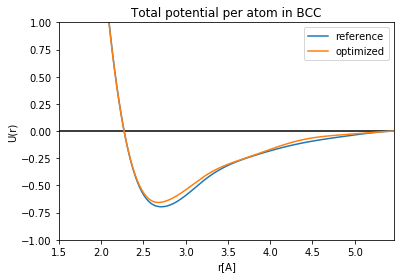

In [189]:
pot = [utot_re(x) for x in r]
pot_new = [utot_opt(x, pair_new, many_new) for x in r]

plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='reference')
plt.plot(r, pot_new, label='optimized')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

In [190]:
# modified functions
many_x = [x for x in many_new]
many_x[1] = 0.0

pair_x = [x for x in pair_new]
pair_x[-1] += 2*many_new[1]

In [191]:
print(pair_x)
print(many_x)

[7.262799609949834, 2.8551814788414784, -1.1750824011719558, 0.5925315310384949, -0.41006381316375573, 0.11876321014440062]
[-0.344540412587315, 0.0]


In [120]:
pair_new

array([ 0.83073149,  6.3064633 ,  2.56944634, -0.21327208, -0.2225459 ,
        0.02275643])

In [121]:
many_new

array([-4.09342761e-01,  3.54237104e-03,  1.53203715e-05])

In [96]:
many_x = [many_x[0], 0.0, 0.0]

Text(0,0.5,'U(r)')

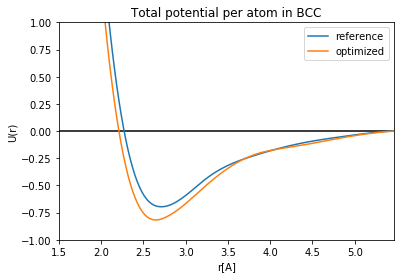

In [97]:
pot = [utot_re(x) for x in r]
pot_new = [utot_opt(x, pair_x, many_x) for x in r]

plt.title('Total potential per atom in BCC')
plt.plot(r, pot, label='reference')
plt.plot(r, pot_new, label='optimized')
plt.legend()
plt.hlines(0.0, 1.5, rcut)
plt.axis([1.5, rcut, -1, 1.0])
plt.xlabel('r[A]')
plt.ylabel(r'U(r)')

In [79]:
print('pair potentail parameters:', *pair_x)
print('embedding function parameters:', *many_x)

pair potentail parameters: 0.8307314918975489 6.306463298847209 2.569446338927059 -0.21327208205268988 -0.22254590199235236 0.02984117320348275
embedding function parameters: -0.4093427610992626 0.0 0.0


In [202]:
pwd

'/Users/l2v/work/force_fields/eam-models/notebooks'